In [11]:
from sympy import *
from sympy.matrices import *
from sympy.plotting import plot
init_printing(use_latex=true)
import operator, functools

t1,t2,t3,t4,t5,t6 = symbols("\\theta_1:7")
d1,d2,d3,d4,d5,d6 = symbols("d_1:7")
a1,a2,a3,a4,a5,a6 = symbols("a_1:7")
x,y,z,t = symbols('x,y,z,t')

def dhs(a,alpha,d,theta):
    M = Matrix([[cos(theta),-sin(theta)*cos(alpha),sin(theta)*sin(alpha),a*cos(theta)],
                  [sin(theta),cos(theta)*cos(alpha),-cos(theta)*sin(alpha),a*sin(theta)],
                  [0,sin(alpha),cos(alpha),d],
                  [0,0,0,1]])
    return M

class Manipulator(object):
    def __init__(self,*args):
        self.Ts = []
        self.type = []
        for k in args:
            self.Ts.append(dhs(k[0],k[1],k[2],k[3]))
            if len(k)>4:
                self.type.append(k[4])
            else:
                self.type.append('r')
        self.dof = len(args)
    
    def z(self,i):
        if i == 0: return Matrix([[0],[0],[1]])
        MTH = eye(4)
        for k in range(i):
            MTH = MTH*self.Ts[k]
        return MTH[:3,2]
    
    def p(self,i):
        if i == 0: return Matrix([[0],[0],[0]])
        MTH = eye(4)
        for k in range(i):
            MTH = MTH*self.Ts[k]
        return MTH[:3,3]
    
    @property
    def J(self):
        n = self.dof
        M_ = zeros(6,n)
        for i in range(self.dof):
            if self.type[i]=='r':
                jp = self.z(i).cross(self.p(n) - self.p(i))
                jo = self.z(i)
            else:
                jp = self.z(i)
                jo = zeros(3,1)
            jp = jp.col_join(jo)
            M_[:,i] = jp
        return simplify(M_)
    
    @property
    def T(self):
        return simplify(functools.reduce(operator.mul, self.Ts))
    
def newton_raphson(J,b,X0,vals,eps=0.001,icg=[t3,t4]):
    ei, k = [], 1
    Jinv = J.inv().subs(vals)
    b = b.subs(vals)
    while True:
        x = (Jinv.subs(X0)*b.subs(X0)).evalf()
        ei.append([x.norm(),X0[icg[0]],X0[icg[1]]])
        if x.norm()<eps: break
        for jj,ky in enumerate(X0):
            X0[ky] += (x[jj]).evalf()
        k += 1
    return X0,x,k,ei


In [12]:
#Fanuc = Manipulator((75,pi/2,330,t1), (300,0,0,t2), (75,-pi/2,0,t3),(0,pi/2,-320,t4),(0,pi/2,0,t5),(0,0,80,t6))
Fanuc = Manipulator((75,pi/2,330,t1), (300,0,0,t2), (75,-pi/2,0,t3))

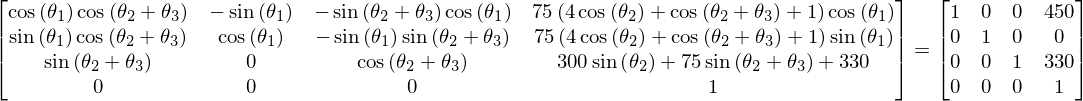

In [33]:
T = Fanuc.T

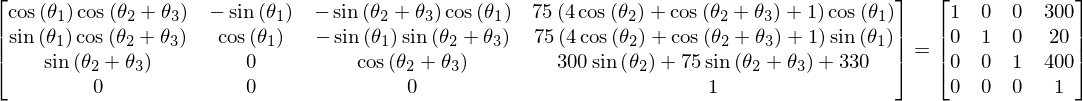

In [43]:
PT = Matrix([[1,0,0,300],
             [0,1,0,20],
             [0,0,1,400],
             [0,0,0,1]])
Eq(T, PT)

In [46]:
# f1 = T[0,0] - PT[0,0]
# f2 = T[1,0] - PT[1,0]
# f3 = T[2,0] - PT[2,0]
# f4 = T[3,0] - PT[3,0]
# f5 = T[0,1] - PT[0,1]
# f6 = T[1,1] - PT[0,0]
f1 = T[0,3] - PT[0,3]
f2 = T[1,3] - PT[1,3]
f3 = T[2,3] - PT[2,3]

F = Matrix([f1,f2,f3])
J = F.jacobian([t1,t2,t3])
b = -F

X0 = {t1:0.1, t2:pi/3, t3:-pi/3}
vals = {}
XS,*_, data = newton_raphson(J,b,X0,vals,1e-4,[t1,t2,t3])

In [47]:
(XS[t1]*180/pi).evalf(), (XS[t2]*180/pi).evalf(), (XS[t3]*180/pi).evalf()